In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
from module import Model_Training
import logging
tf.get_logger().setLevel(logging.ERROR)


2023-03-09 07:34:29.988988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 07:34:30.490172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64:/home/jj/miniconda3/envs/tf/lib/
2023-03-09 07:34:30.490246: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LI

In [2]:
# full_img_path = '/mnt/d/Datasets/CBIS_DDSM/full/'
roi_img_path = '/mnt/d/CBIS-DDSM/new_ROI/resize_GCN/'
img_height = 300
img_width = 300
batch_size = 16
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
misclassified_store = '/mnt/c/Users/user/Desktop/GCN_CBIS_DDSM_misclassified/'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)
train = train_ds.prefetch(AUTOTUNE)
val = val_ds.prefetch(AUTOTUNE)

Found 6648 files belonging to 2 classes.
Found 183 files belonging to 2 classes.


In [4]:
test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'test/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
train_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'train/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
val_test = tf.keras.utils.image_dataset_from_directory(
  roi_img_path+'val/',
  label_mode="categorical",
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=batch_size)
# test = test_ds.prefetch(AUTOTUNE)

Found 311 files belonging to 2 classes.
Found 6648 files belonging to 2 classes.
Found 183 files belonging to 2 classes.


In [5]:
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(
            f' Epoch {epoch}: accuracy={logs["categorical_accuracy"]:.4f}, loss={logs["loss"]:.4f}, '+
            f'val_accuracy={logs["val_categorical_accuracy"]:.4f}, val_loss={logs["val_loss"]:.4f}, '+
            f' - lr={lr:.7f}')
Model_Training = Model_Training()

# Inception V3

In [6]:
train_log = '/home/jj/FYP/log/InceptionV3_CBIS_DDSM/'
weight = '/home/jj/FYP/Checkpoint/InceptionV3_CBIS_DDSM/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

2023-03-09 00:22:38.060420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-09 00:22:40.302097: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-03-09 00:22:40.996926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-09 00:22:41.016120: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f92cc04e220 initialized for platform CUDA (this does not guarantee

416/416 [==============================] - 391s 899ms/step - loss: 2.3120 - categorical_accuracy: 0.4896 - recall: 0.7680 - recall_1: 0.2362 - val_loss: 2.2635 - val_categorical_accuracy: 0.5355 - val_recall: 0.1951 - val_recall_1: 0.8119
Epoch 2/2
416/416 [==============================] - 70s 168ms/step - loss: 2.0318 - categorical_accuracy: 0.5582 - recall: 0.3482 - recall_1: 0.7494 - val_loss: 1.8165 - val_categorical_accuracy: 0.5847 - val_recall: 0.5488 - val_recall_1: 0.6139
Epoch 3/3
416/416 [==============================] - 69s 166ms/step - loss: 1.5196 - categorical_accuracy: 0.6121 - recall: 0.5713 - recall_1: 0.6491 - val_loss: 1.2892 - val_categorical_accuracy: 0.6120 - val_recall: 0.4634 - val_recall_1: 0.7327
Epoch 4/4
416/416 [==============================] - 69s 166ms/step - loss: 1.0610 - categorical_accuracy: 0.6501 - recall: 0.6379 - recall_1: 0.6612 - val_loss: 0.9123 - val_categorical_accuracy: 0.6776 - val_recall: 0.7195 - val_recall_1: 0.6436
Epoch 5/5
416/416

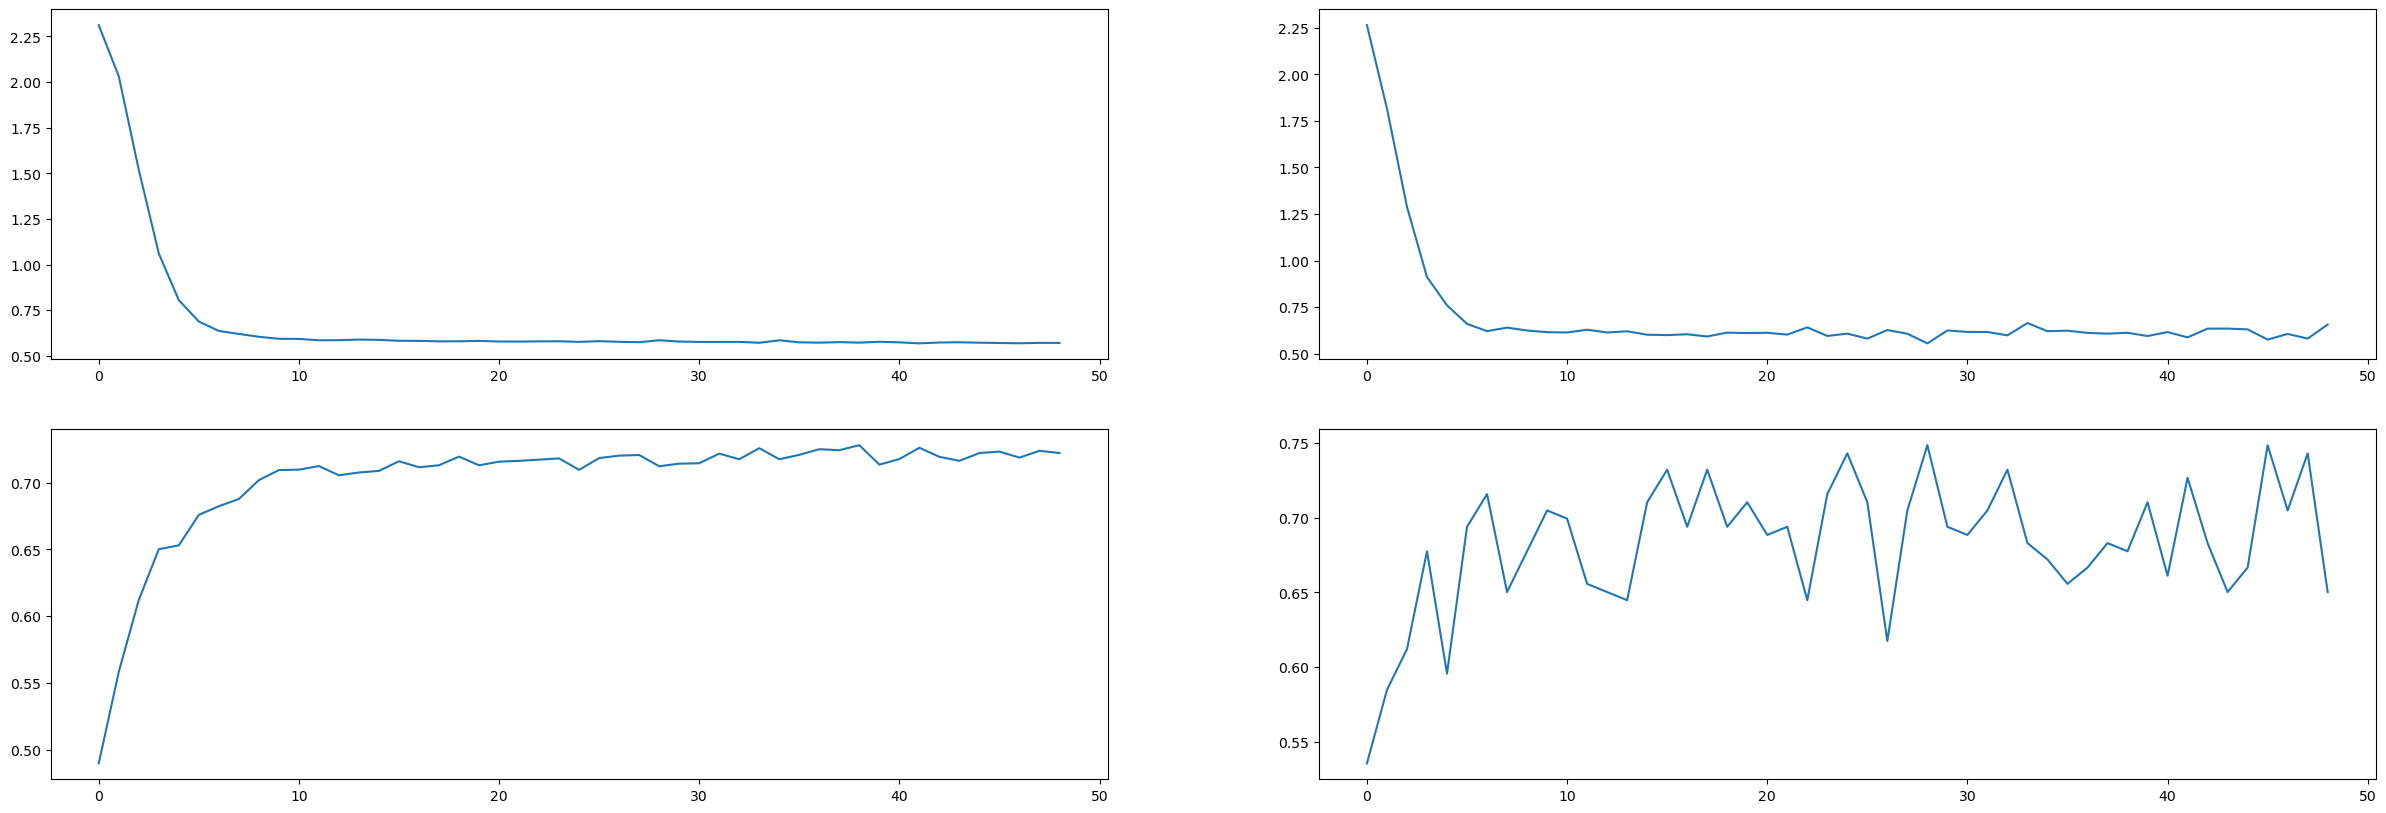

In [7]:
tf.keras.backend.clear_session()
model, inception_dense_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'dense.csv',
    load_weights = False,
    save_weights = weight+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

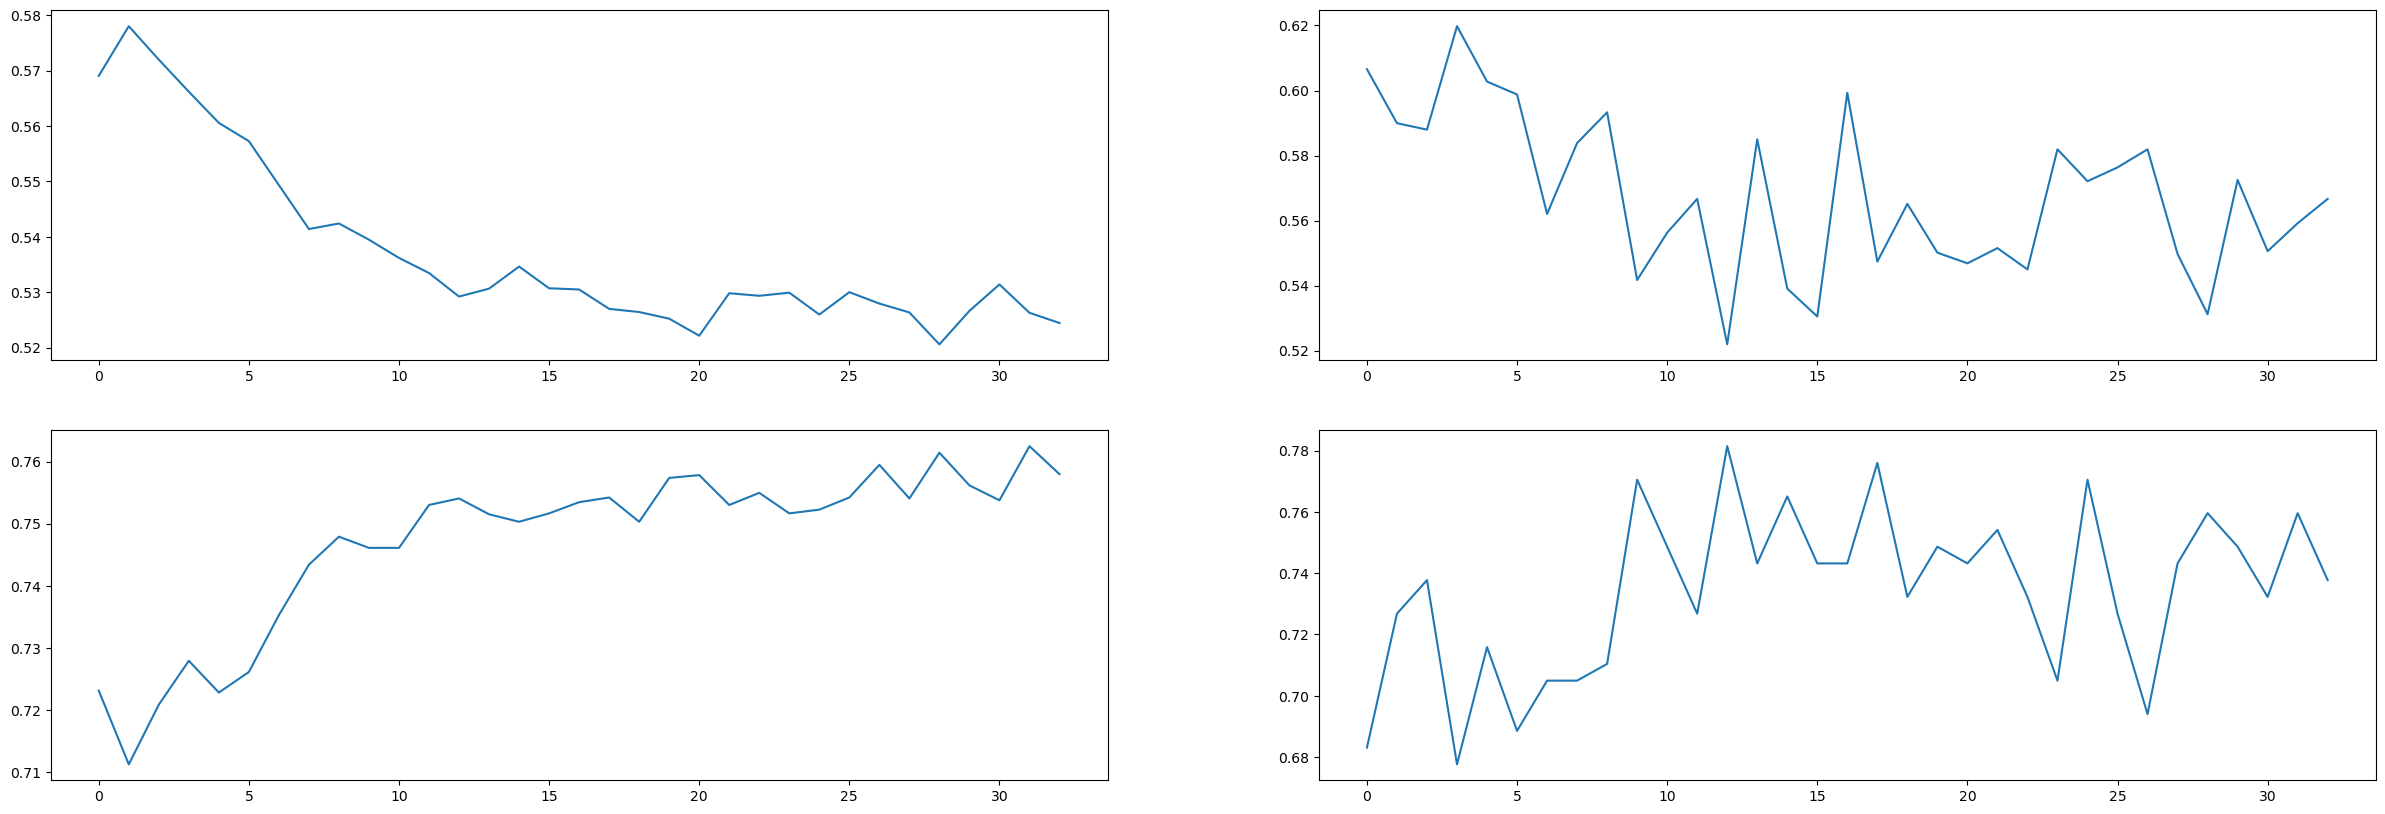

In [8]:
tf.keras.backend.clear_session()
model, inception_fine_tune_history = Model_Training.main(    
    'inceptionv3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    flatten='global_average_pooling',
    trainable_layers = 63,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log=train_log+'Fine_Tune.csv',
    load_weights = weight+'Dense/best_model',
    save_weights = weight+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [7]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('inceptionv3',augmentation=False,Flatten='global_average_pooling',load_weights=weight+'/Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [8]:
store_misclassified = misclassified_store+'inceptionv3/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

2023-03-09 07:34:52.817897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-09 07:34:54.240986: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


 5/20 [======>.......................] - ETA: 0s - loss: 0.8193 - categorical_accuracy: 0.6500 - precision: 0.6500 - recall: 0.6500 - auc: 0.6047 

2023-03-09 07:34:54.913636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


12/12 [==============================] - 1s 62ms/step


20/20 [==============================] - 1s 34ms/step


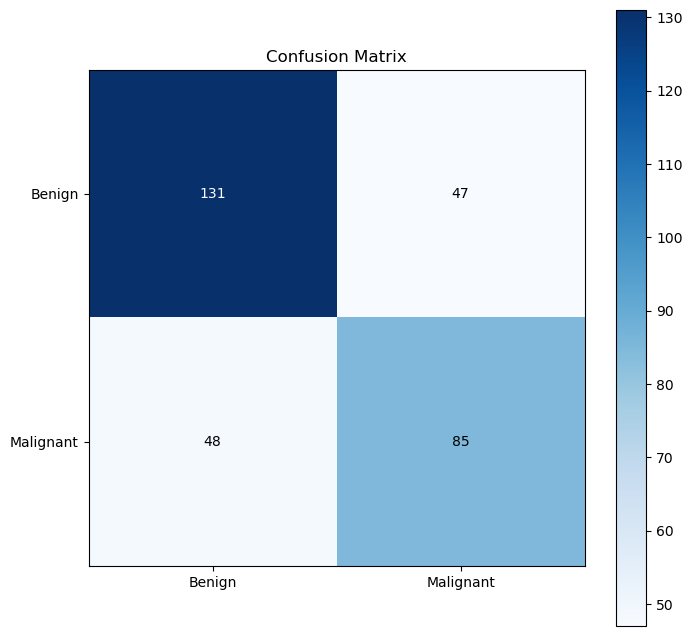

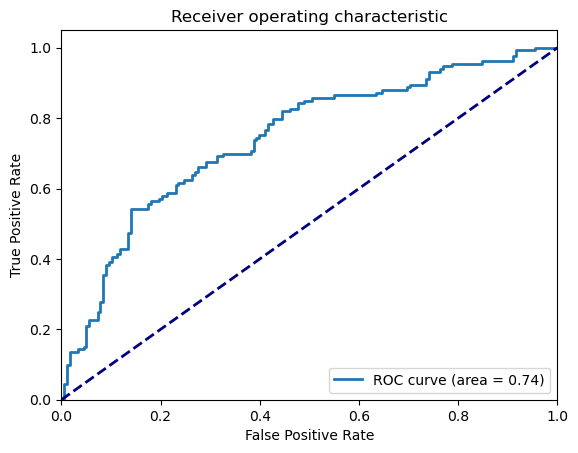

In [9]:
model.load_weights(weight+'/Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

Image without padding, normalisation used

21/21 [==============================] - 2s 40ms/step - loss: 0.8528 - categorical_accuracy: 0.7019 - precision_2: 0.7778 - precision_3: 0.6331


# Resnet50

## Initialising

In [10]:
weights = '/home/jj/FYP/Checkpoint/Resnet50_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Resnet50_CBIS_DDSM/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

2023-03-09 07:36:01.270642: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f45b8059f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-09 07:36:01.270667: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-09 07:36:01.289747: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-09 07:36:01.459455: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


416/416 [==============================] - 81s 182ms/step - loss: 2.3060 - categorical_accuracy: 0.4988 - precision: 0.4798 - precision_1: 0.5286 - val_loss: 2.2582 - val_categorical_accuracy: 0.5464 - val_precision: 0.4286 - val_precision_1: 0.5511
Epoch 2/2
416/416 [==============================] - 72s 174ms/step - loss: 2.0055 - categorical_accuracy: 0.5916 - precision: 0.5737 - precision_1: 0.6070 - val_loss: 1.7739 - val_categorical_accuracy: 0.6175 - val_precision: 0.5625 - val_precision_1: 0.6782
Epoch 3/3
416/416 [==============================] - 72s 174ms/step - loss: 1.4676 - categorical_accuracy: 0.6527 - precision: 0.6392 - precision_1: 0.6643 - val_loss: 1.2329 - val_categorical_accuracy: 0.6831 - val_precision: 0.5984 - val_precision_1: 0.8525
Epoch 4/4
416/416 [==============================] - 72s 173ms/step - loss: 1.0194 - categorical_accuracy: 0.6849 - precision: 0.6641 - precision_1: 0.7049 - val_loss: 0.8684 - val_categorical_accuracy: 0.6721 - val_precision: 0.6

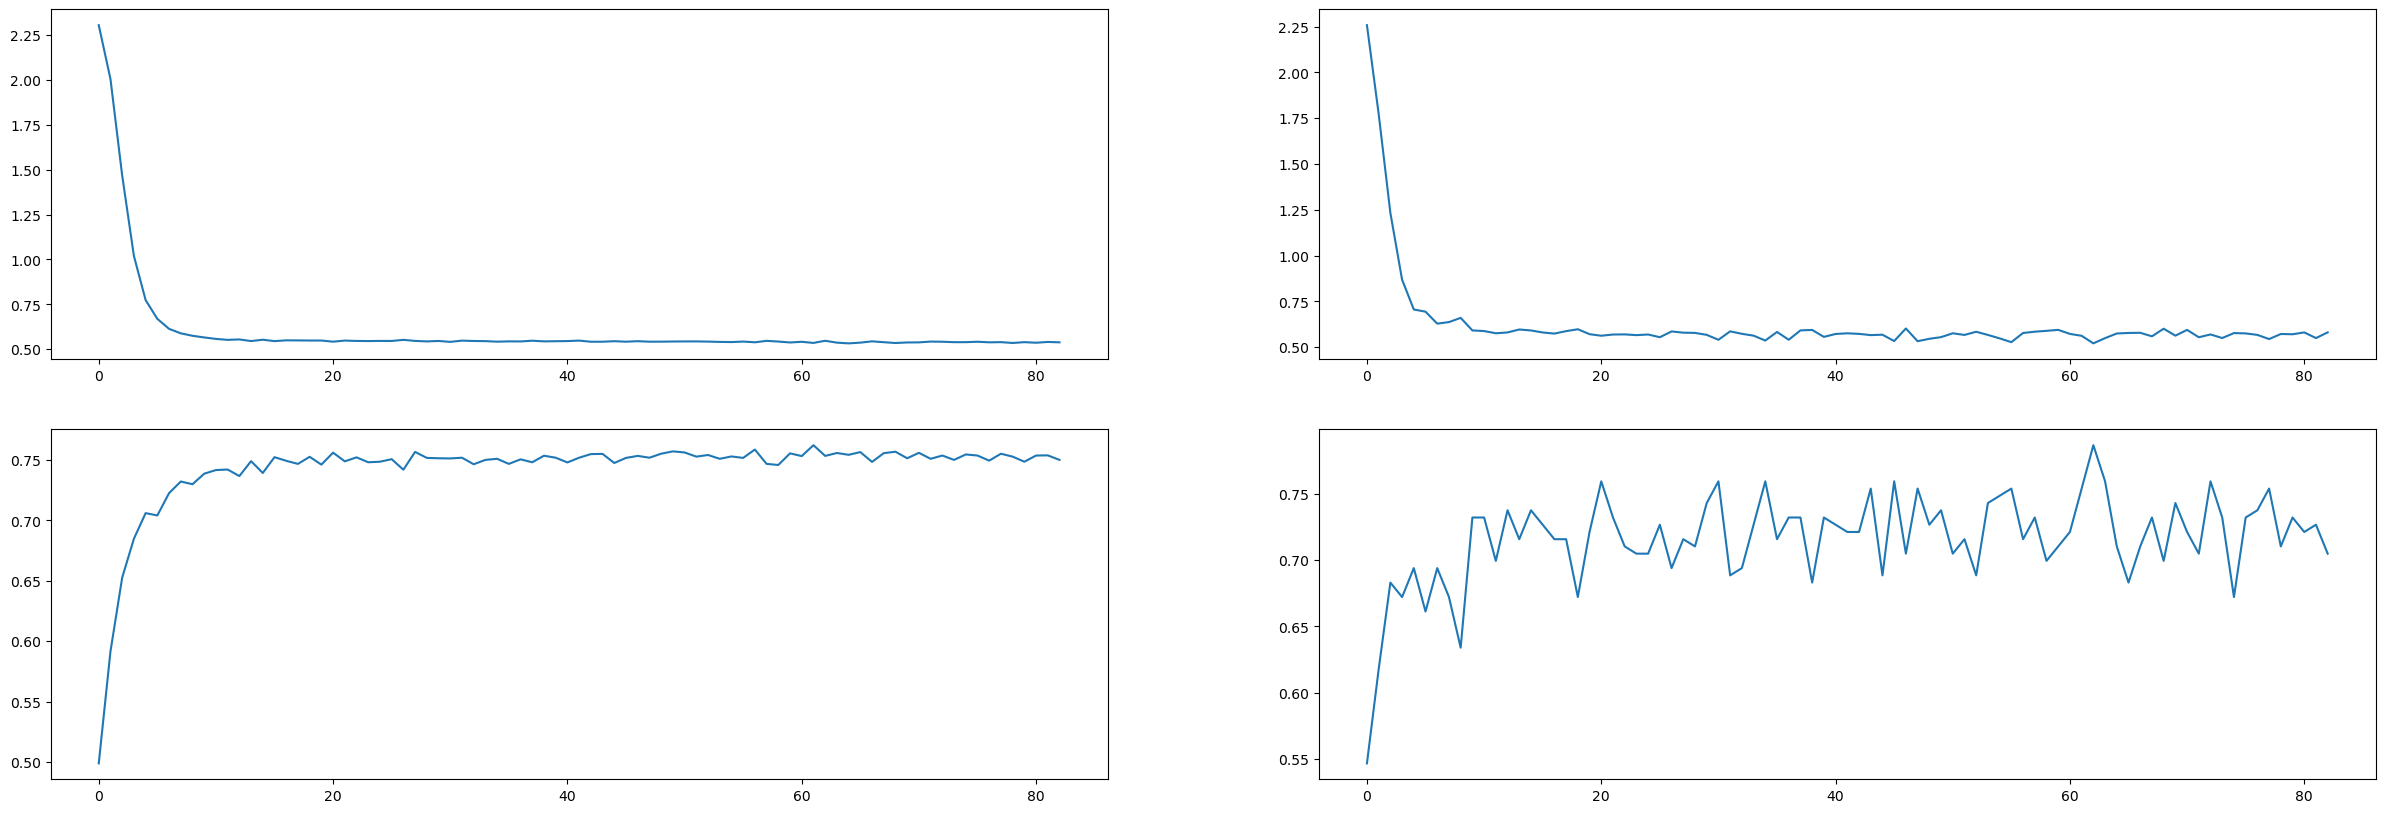

In [11]:
tf.keras.backend.clear_session()
model, resnet_dense_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

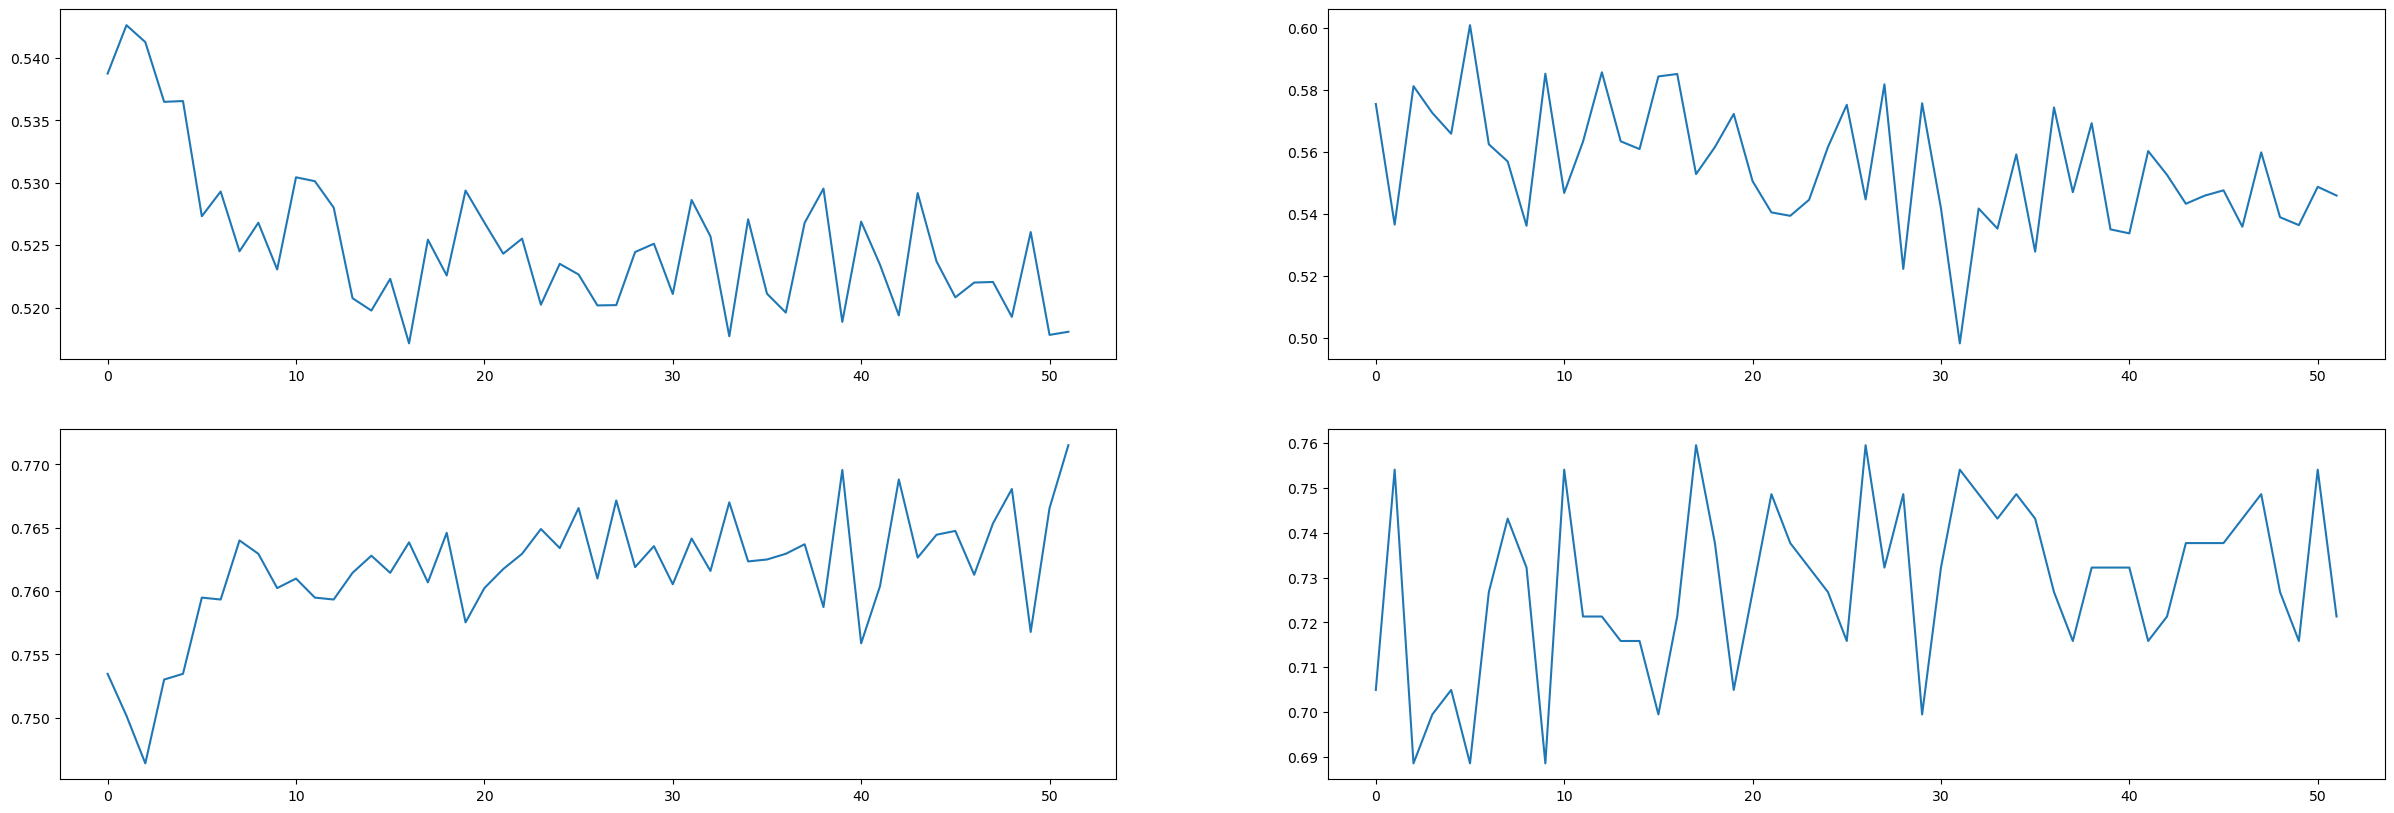

In [12]:
tf.keras.backend.clear_session()
model, resnet_fine_tune_history = Model_Training.main(    
    'resnet50',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 22,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [13]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('resnet50',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              419635

In [14]:
store_misclassified = misclassified_store+'resnet50/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 59ms/step


20/20 [==============================] - 1s 42ms/step


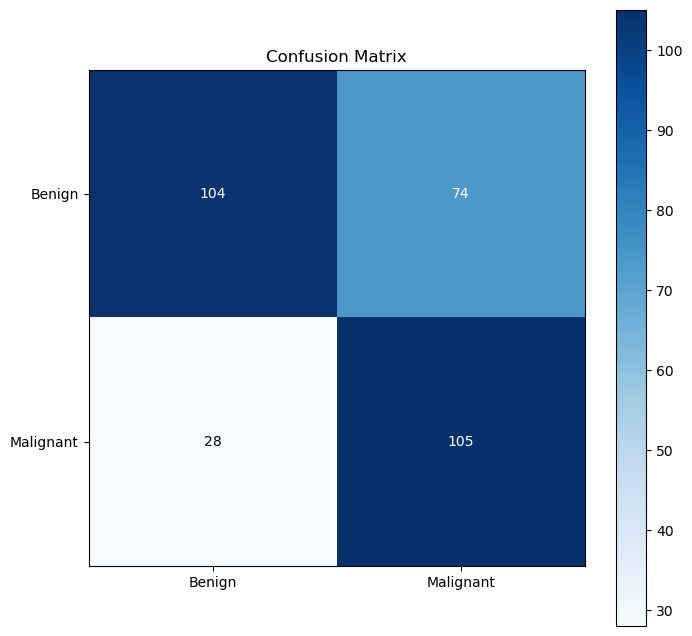

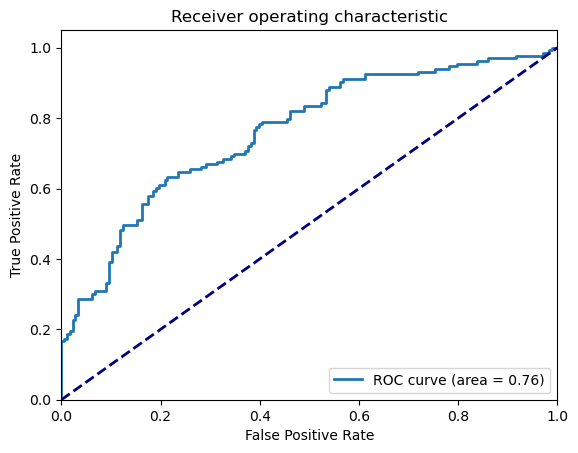

In [15]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# VGG16

In [16]:
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

2023-03-09 10:21:08.471257: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 10:21:08.475696: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


416/416 [==============================] - 78s 174ms/step - loss: 2.3393 - categorical_accuracy: 0.5269 - precision: 0.5033 - precision_1: 0.5522 - val_loss: 2.2444 - val_categorical_accuracy: 0.5574 - val_precision: 0.5036 - val_precision_1: 0.7174
Epoch 2/2
416/416 [==============================] - 69s 165ms/step - loss: 2.0491 - categorical_accuracy: 0.5275 - precision: 0.5043 - precision_1: 0.5479 - val_loss: 1.8459 - val_categorical_accuracy: 0.5738 - val_precision: 0.5435 - val_precision_1: 0.5839
Epoch 3/3
416/416 [==============================] - 69s 166ms/step - loss: 1.5745 - categorical_accuracy: 0.5877 - precision: 0.5812 - precision_1: 0.5919 - val_loss: 1.3520 - val_categorical_accuracy: 0.5628 - val_precision: 0.5077 - val_precision_1: 0.6981
Epoch 4/4
416/416 [==============================] - 69s 166ms/step - loss: 1.1505 - categorical_accuracy: 0.6224 - precision: 0.5982 - precision_1: 0.6471 - val_loss: 1.0143 - val_categorical_accuracy: 0.5902 - val_precision: 0.5

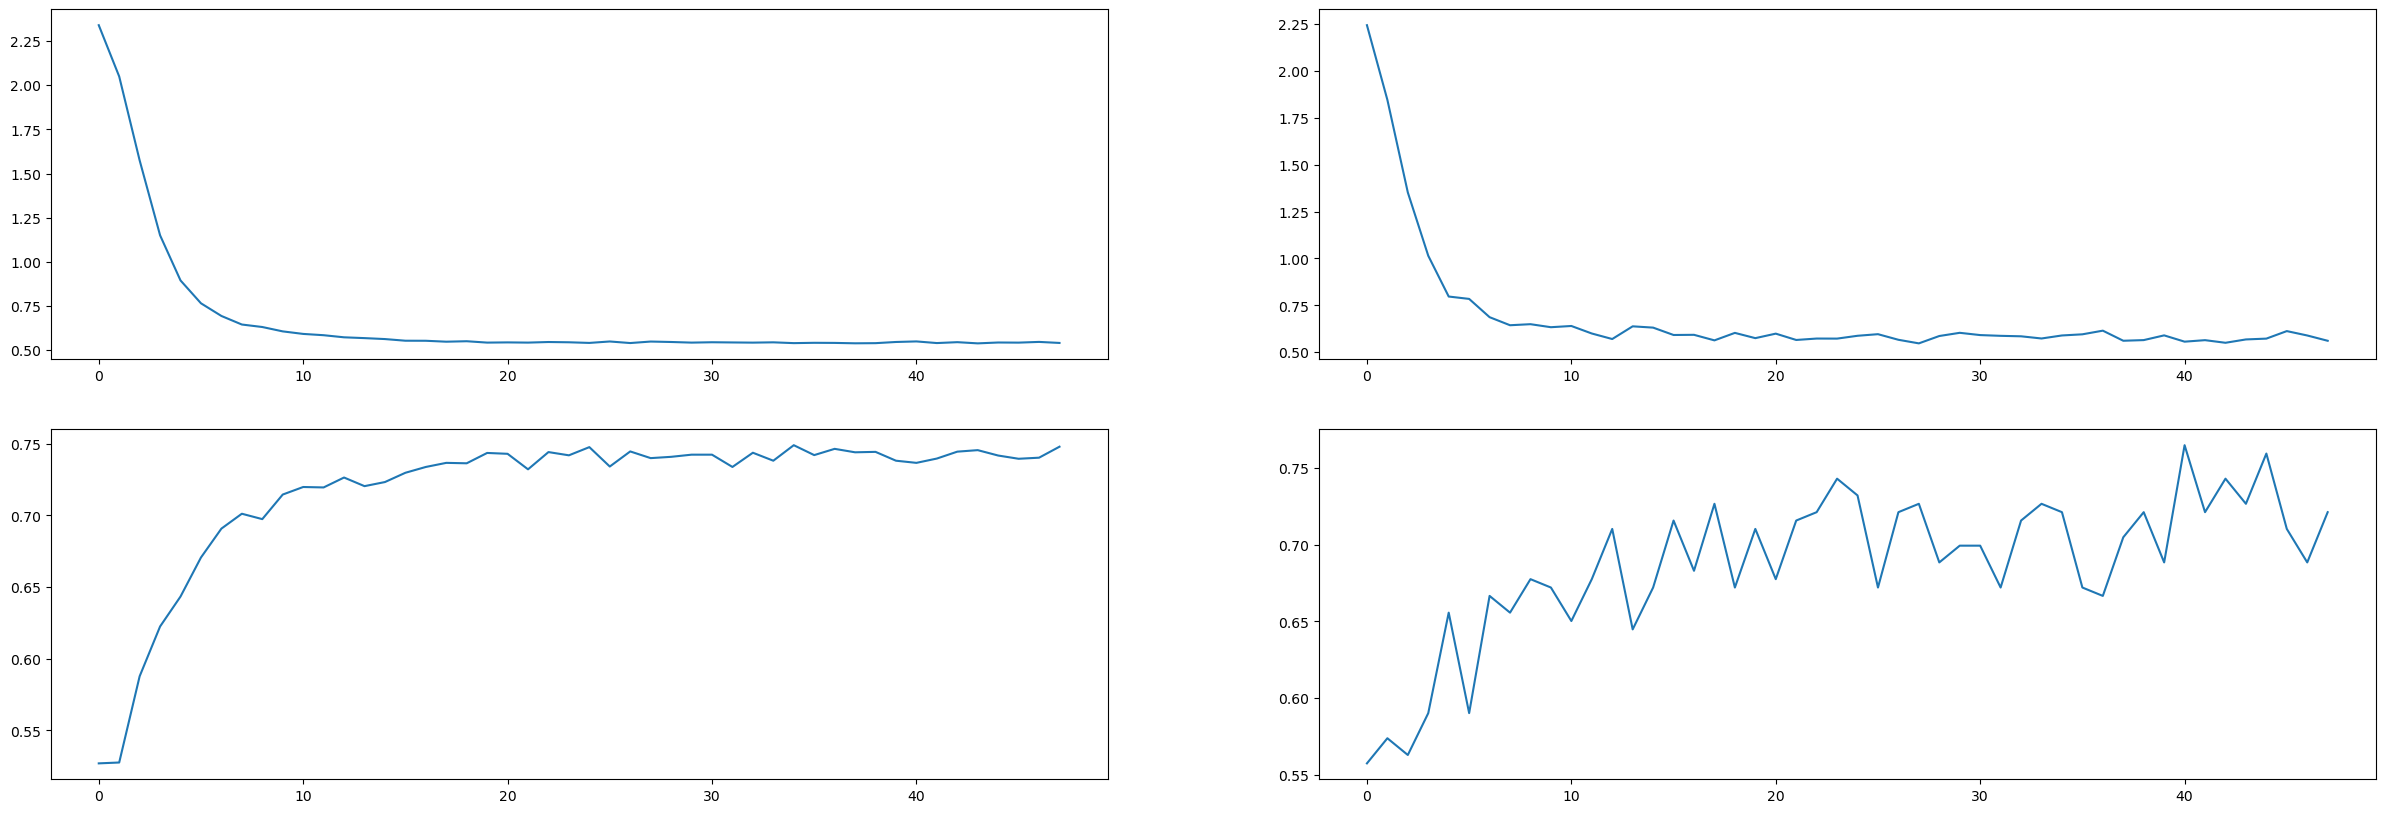

In [17]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Vgg16_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Vgg16_CBIS_DDSM/'
model, vgg16_dense_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

2023-03-09 11:16:54.536966: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 11:16:54.537007: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 11:16:54.574535: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-09 11:16:54.574573: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

416/416 [==============================] - 100s 233ms/step - loss: 0.5486 - categorical_accuracy: 0.7347 - precision: 0.7081 - precision_1: 0.7621 - val_loss: 0.5793 - val_categorical_accuracy: 0.6940 - val_precision: 0.6444 - val_precision_1: 0.7419
Epoch 2/2
416/416 [==============================] - 95s 229ms/step - loss: 0.5458 - categorical_accuracy: 0.7440 - precision: 0.7233 - precision_1: 0.7641 - val_loss: 0.5774 - val_categorical_accuracy: 0.7213 - val_precision: 0.6703 - val_precision_1: 0.7717
Epoch 3/3
416/416 [==============================] - 95s 228ms/step - loss: 0.5414 - categorical_accuracy: 0.7441 - precision: 0.7233 - precision_1: 0.7645 - val_loss: 0.5709 - val_categorical_accuracy: 0.7158 - val_precision: 0.6630 - val_precision_1: 0.7692
Epoch 4/4
416/416 [==============================] - 95s 228ms/step - loss: 0.5375 - categorical_accuracy: 0.7491 - precision: 0.7269 - precision_1: 0.7711 - val_loss: 0.5847 - val_categorical_accuracy: 0.6995 - val_precision: 0.

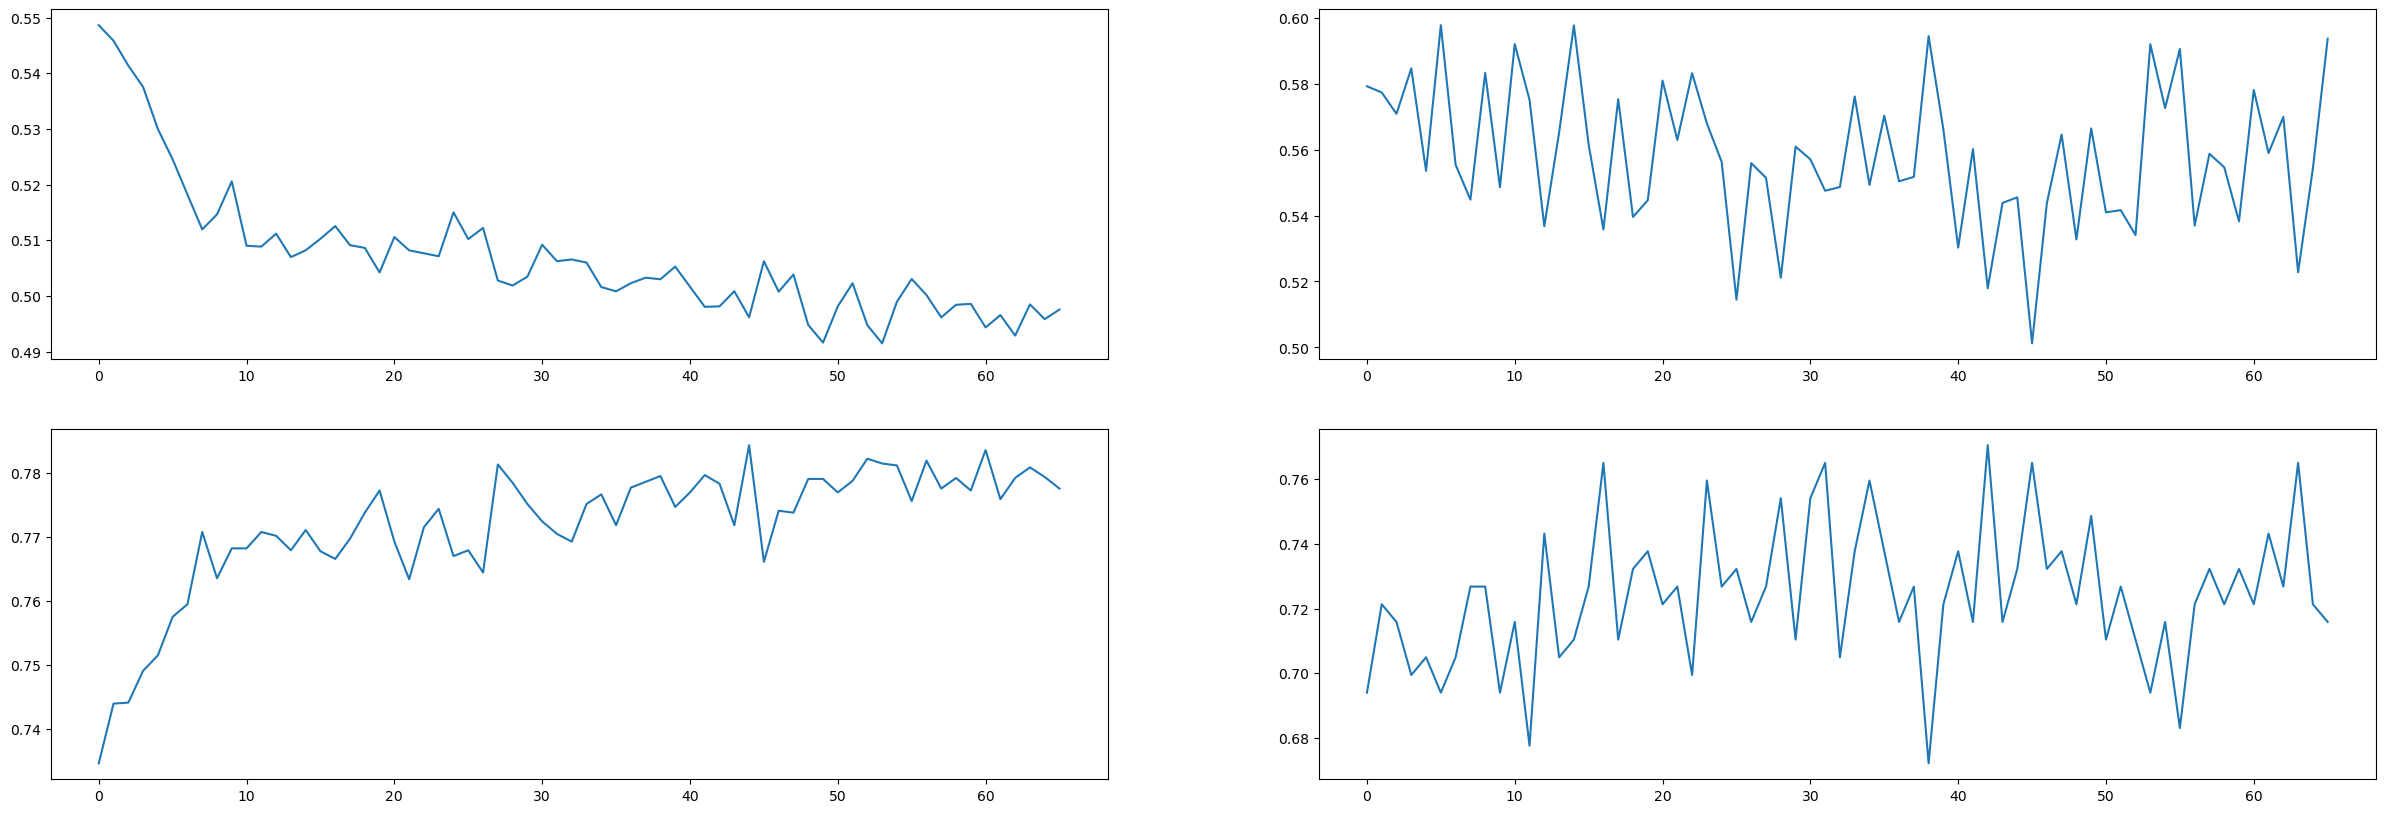

In [18]:
tf.keras.backend.clear_session()
model, vgg16_fine_tune_history = Model_Training.main(    
    'vgg16',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 16,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [19]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]

model = Model_Training.build_model('vgg16',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 300, 300, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 300, 300, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              105062

In [20]:
store_misclassified = misclassified_store+'vgg16/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 69ms/step


20/20 [==============================] - 1s 45ms/step


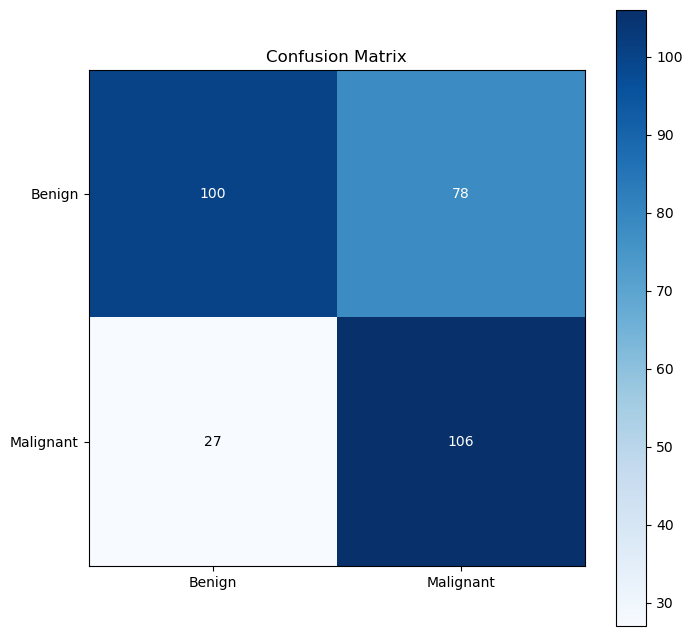

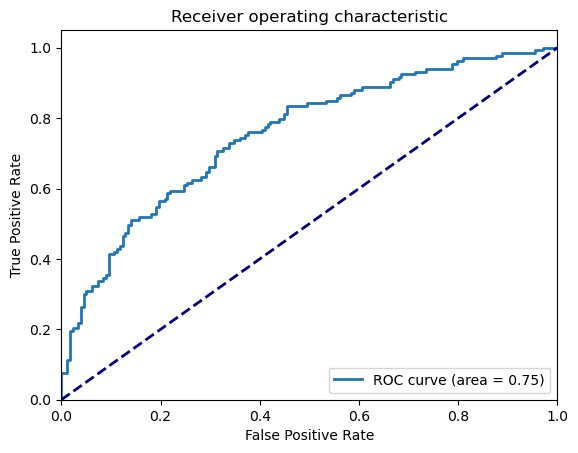

In [21]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# EfficientNet

In [22]:
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              3147776   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

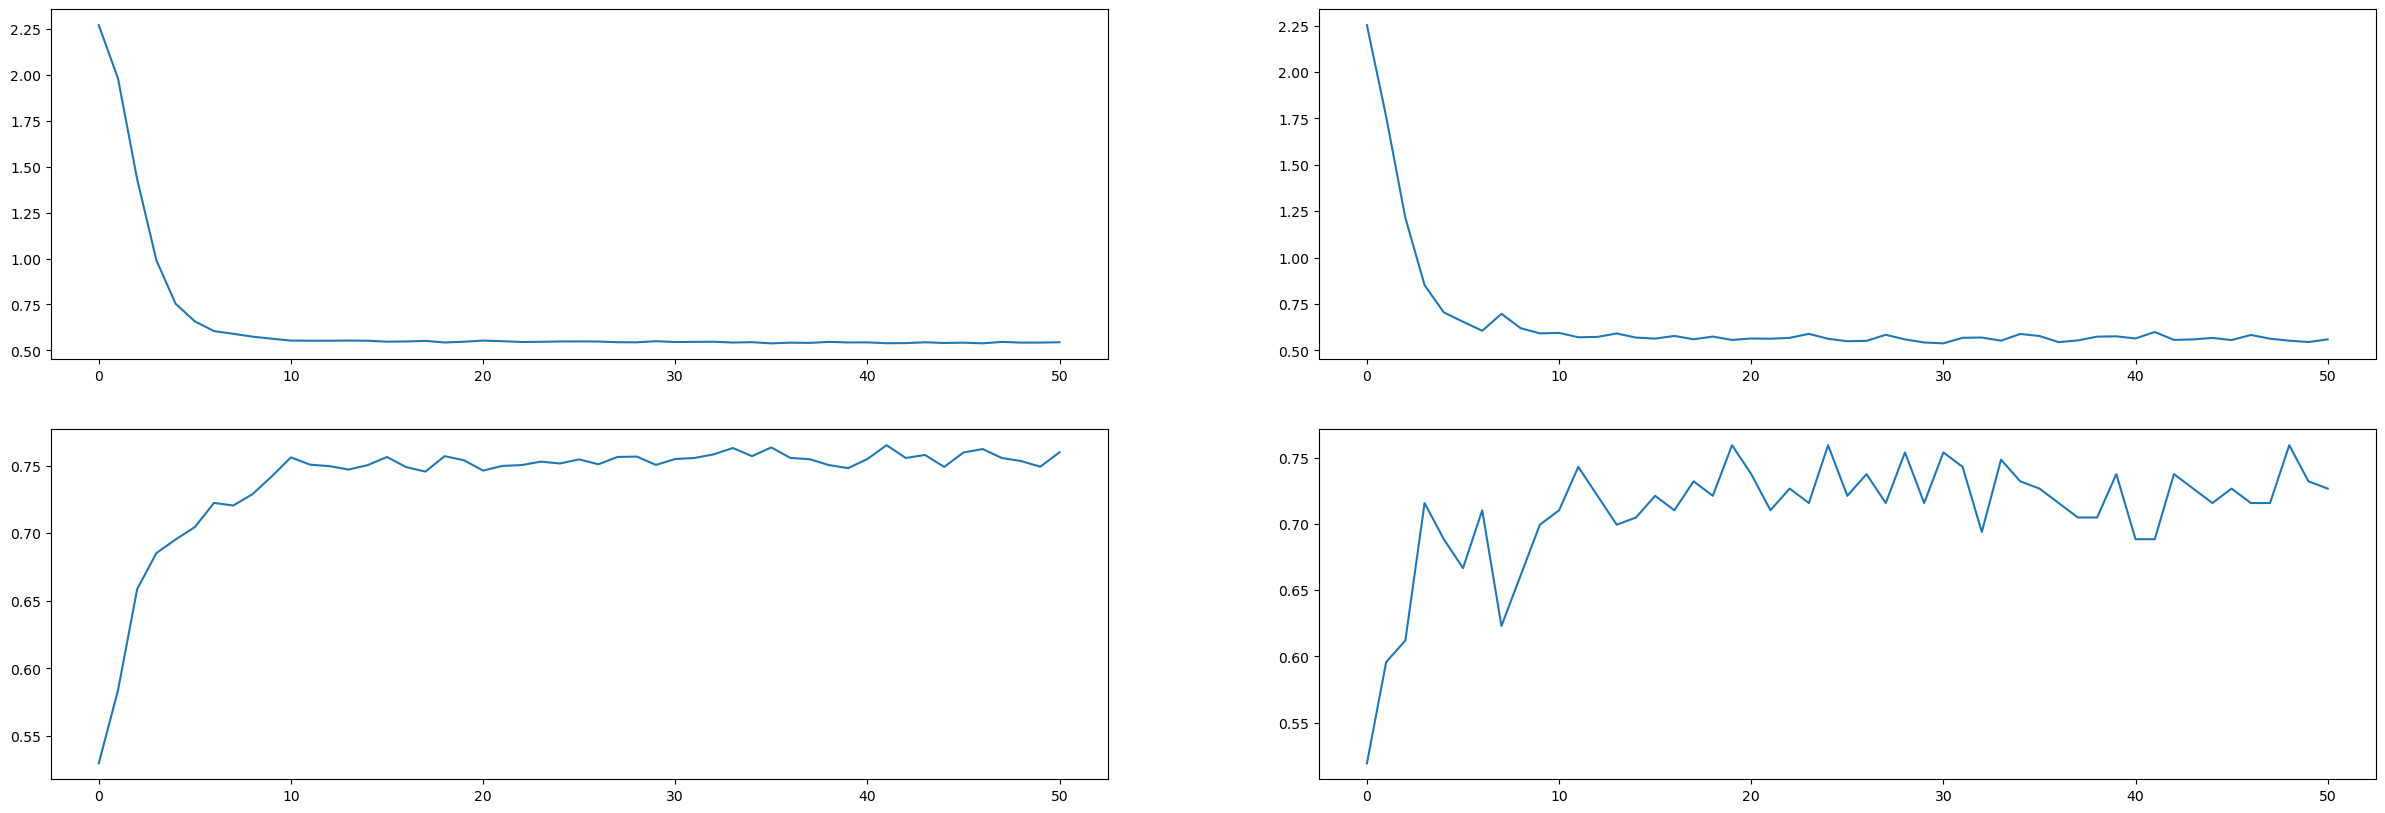

In [23]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/EffcientNetB3_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/EffcientNetB3_CBIS_DDSM/'
model, effnet_dense_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)
tf.keras.backend.clear_session()

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              3147776   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

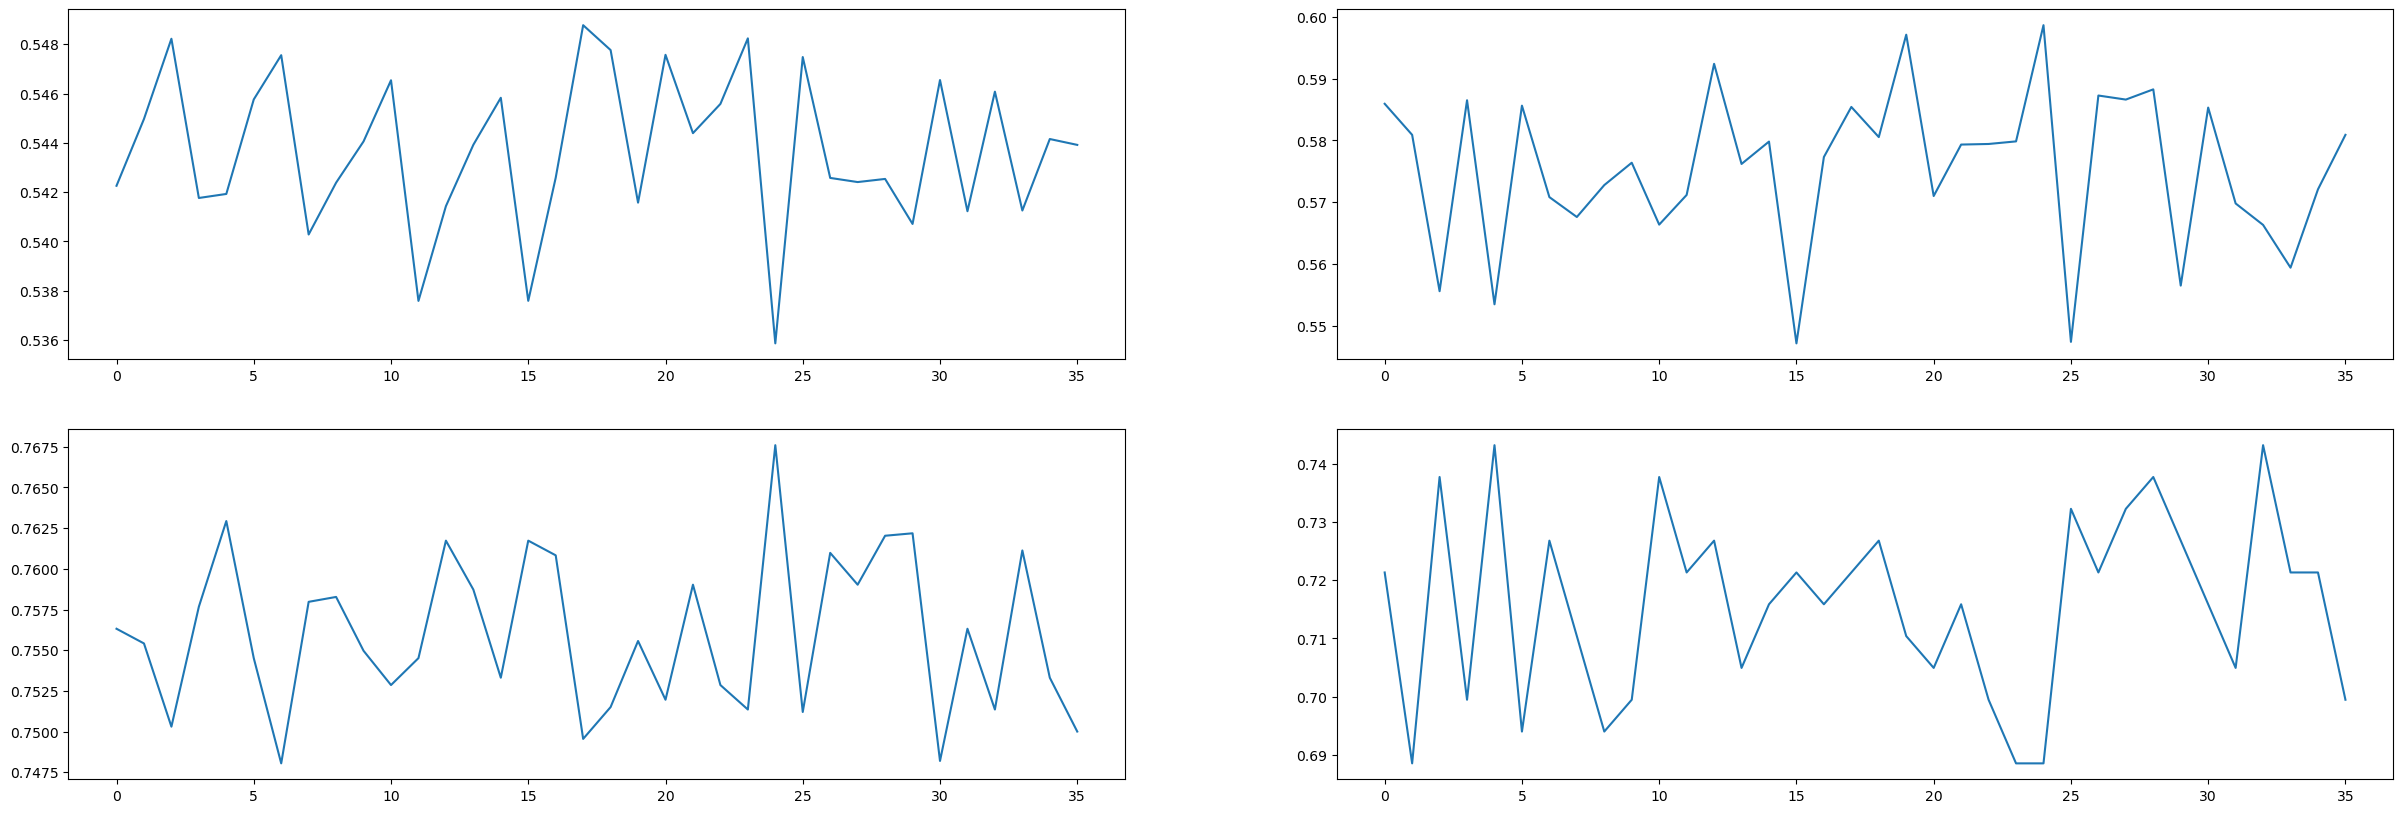

In [24]:
tf.keras.backend.clear_session()
model, effnet_fine_tune_history = Model_Training.main(    
    'efficientnetb3',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-5,init_lr=1e-7,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Recall(class_id=0),tf.keras.metrics.Recall(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [25]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('efficientnetb3',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              3147776   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                             

In [26]:
store_misclassified = misclassified_store+'efficientnetb3/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 1s 86ms/step


20/20 [==============================] - 1s 58ms/step


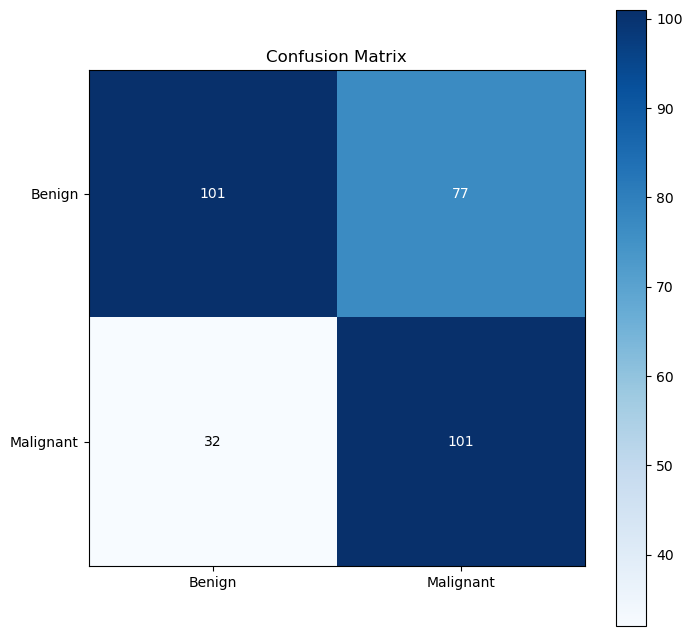

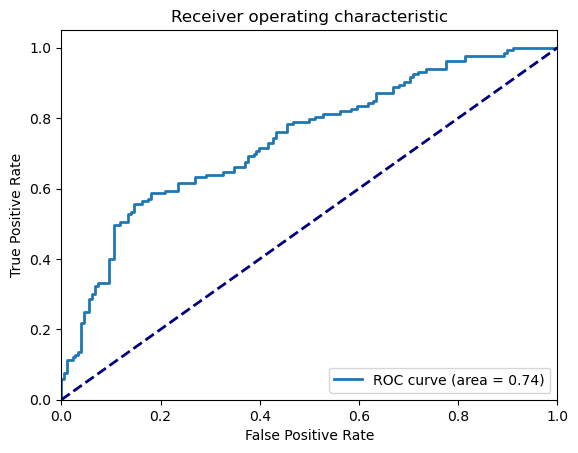

In [27]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# ConvNext

In [28]:
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM/'

In [29]:
tf.keras.backend.clear_session()
model, convnext_dense_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

KeyboardInterrupt: 

## Fine Tune

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

2023-03-08 19:06:39.799428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-08 19:06:41.771970: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc9290db140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 19:06:41.771997: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-03-08 19:06:42.288770: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-03-08 19:06:42.295763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


417/417 [==============================] - 179s 392ms/step - loss: 0.5032 - categorical_accuracy: 0.7864 - precision: 0.7655 - precision_1: 0.8067 - val_loss: 0.5539 - val_categorical_accuracy: 0.7322 - val_precision: 0.6941 - val_precision_1: 0.7653
Epoch 2/2
417/417 [==============================] - 158s 377ms/step - loss: 0.5009 - categorical_accuracy: 0.7843 - precision: 0.7656 - precision_1: 0.8022 - val_loss: 0.5421 - val_categorical_accuracy: 0.7486 - val_precision: 0.6915 - val_precision_1: 0.8090
Epoch 3/3
417/417 [==============================] - 157s 376ms/step - loss: 0.5040 - categorical_accuracy: 0.7746 - precision: 0.7535 - precision_1: 0.7950 - val_loss: 0.5167 - val_categorical_accuracy: 0.7596 - val_precision: 0.7021 - val_precision_1: 0.8202
Epoch 4/4
417/417 [==============================] - 157s 376ms/step - loss: 0.5033 - categorical_accuracy: 0.7788 - precision: 0.7567 - precision_1: 0.8004 - val_loss: 0.5598 - val_categorical_accuracy: 0.7268 - val_precision:

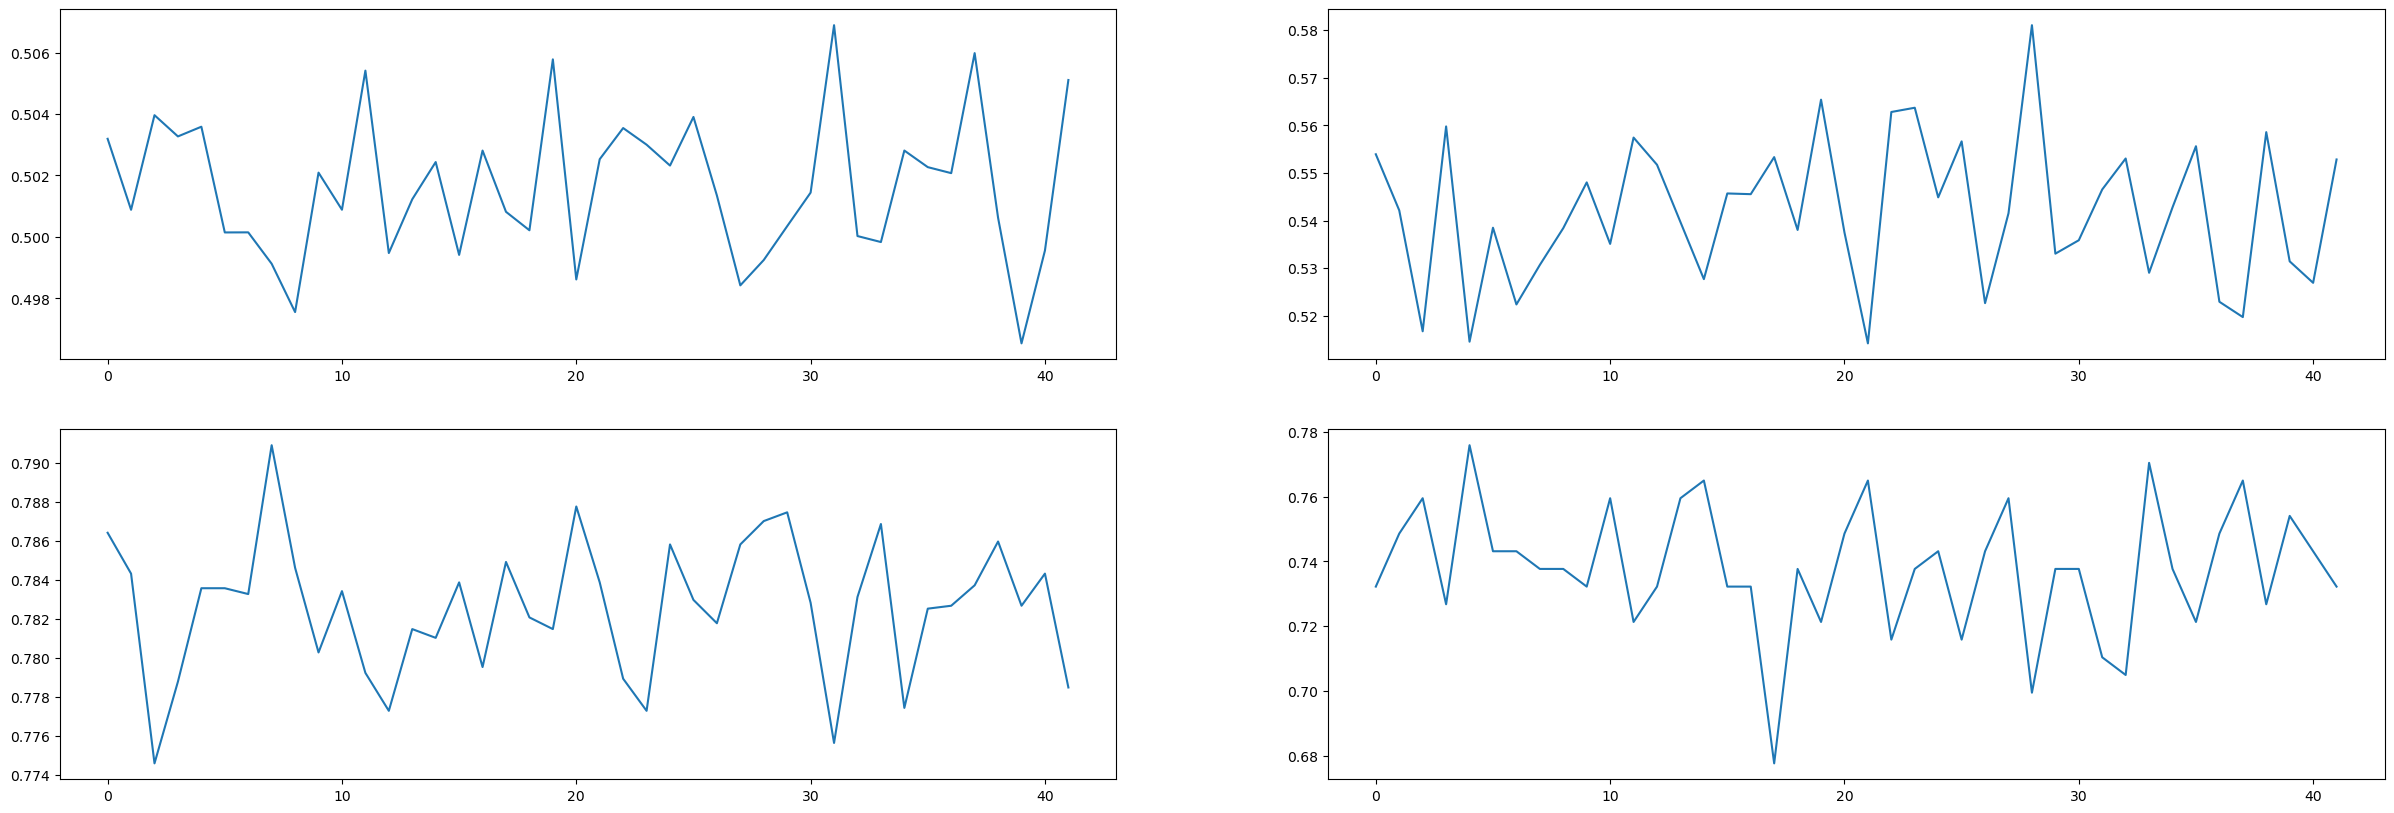

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Convnext_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Convnext_CBIS_DDSM/'
model, convnext_fine_tune_history = Model_Training.main(    
    'convnext',
    train,
    val,
    epochs=300,
    patience=2,
    Earlystop=20,
    augmentation = True,
    # Top 25 layers are the stage 3 blocks
    trainable_layers = 25,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

## Test

In [ ]:
tf.keras.backend.clear_session()
metric = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=1),tf.keras.metrics.Recall(class_id=1),
          tf.keras.metrics.AUC()]
model = Model_Training.build_model('convnext',augmentation=False,Flatten='global_average_pooling',load_weights=weights+'Fine_Tune/best_model',metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 9, 9, 1024)        87566464  
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              2099200   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                             

In [ ]:
store_misclassified = misclassified_store+'convnext/'
model.evaluate(test)
misclassified_inceptionv3_test = Model_Training.store_misclassified(model,test,store_misclassified+'test/')
misclassified_inceptionv3_train = Model_Training.store_misclassified(model,train_test,store_misclassified+'train/')
misclassified_inceptionv3_val = Model_Training.store_misclassified(model,val_test,store_misclassified+'val/')

12/12 [==============================] - 3s 215ms/step


20/20 [==============================] - 4s 217ms/step


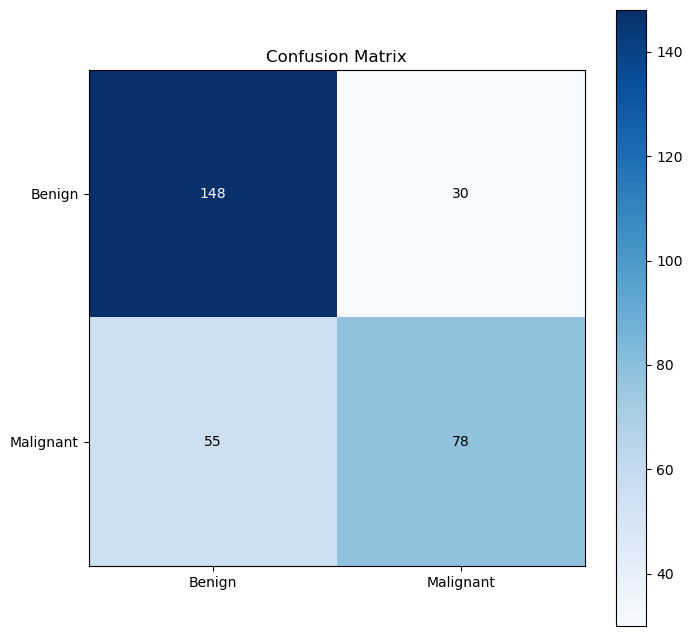

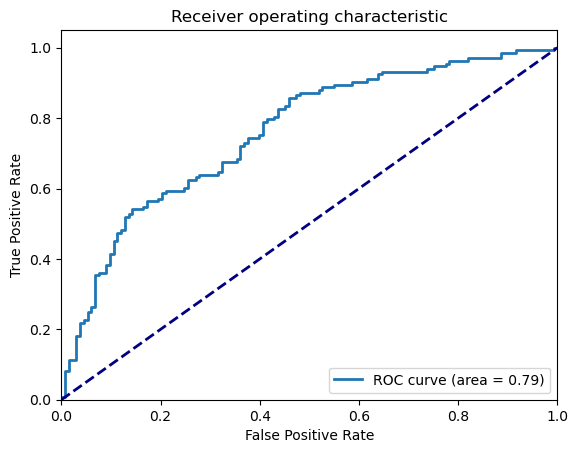

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

# EfficientNet V2M

## Initialising

In [ ]:
tf.keras.backend.clear_session()
weights = '/home/jj/FYP/Checkpoint/Efficientnetv2m_CBIS_DDSM/'
train_log = '/home/jj/FYP/log/Efficientnetv2m_CBIS_DDSM/'
model, effnetv2m_dense_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = False,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'dense.csv',
    load_weights = False,
    save_weights = weights+'Dense/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.Adam(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 8)                 1024008   
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                             

## Fine Tuning

In [ ]:
tf.keras.backend.clear_session()
model, effnetv2m_fine_tune_history = Model_Training.main(    
    'efficientnetv2m',
    train,
    val,
    epochs=100,
    patience=2,
    Earlystop=20,
    augmentation = True,
    trainable_layers = 75,
    regulariser=tf.keras.regularizers.l2(l2=0.1),
    train_log= train_log+'Fine_Tune.csv',
    load_weights = weights+'Dense/best_model',
    save_weights = weights+'Fine_Tune/best_model',
    learning_rate=1e-4,init_lr=1e-6,
    optimiser=tf.keras.optimizers.legacy.SGD(),
    losses = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Precision(class_id=0),tf.keras.metrics.Precision(class_id=1)],
    callbacks = [PrintLR()],
    img_height=img_height,img_width=img_width)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1024008   
                                                                 
 dense_5 (Dense)             (None, 8)                 72        
                                                           

2023-02-22 02:34:36.165409: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.166066: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.178397: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:34:36.178425: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

102/102 [==============================] - ETA: 0s - loss: 1.4916 - categorical_accuracy: 0.5724 - precision_2: 0.5415 - precision_3: 0.6320

2023-02-22 02:35:01.563317: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-22 02:35:01.563354: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 Epoch 0: accuracy=0.5724, loss=1.4916, val_accuracy=0.6412, val_loss=1.4200,  - lr=0.0010000
102/102 [==============================] - 41s 301ms/step - loss: 1.4916 - categorical_accuracy: 0.5724 - precision_2: 0.5415 - precision_3: 0.6320 - val_loss: 1.4200 - val_categorical_accuracy: 0.6412 - val_precision_2: 0.6344 - val_precision_3: 0.6463
Epoch 2/2
102/102 [==============================] - 29s 279ms/step - loss: 1.4567 - categorical_accuracy: 0.5362 - precision_2: 0.5128 - precision_3: 0.5965 - val_loss: 1.3928 - val_categorical_accuracy: 0.6481 - val_precision_2: 0.6210 - val_precision_3: 0.6761
Epoch 3/3
102/102 [==============================] - 29s 278ms/step - loss: 1.4083 - categorical_accuracy: 0.5755 - precision_2: 0.5427 - precision_3: 0.6434 - val_loss: 1.3608 - val_categorical_accuracy: 0.6435 - val_precision_2: 0.6491 - val_precision_3: 0.6398
Epoch 4/4
102/102 [==============================] - 29s 278ms/step - loss: 1.3811 - categorical_accuracy: 0.5583 - precisio

## Test

In [ ]:
model.load_weights(weights+'Fine_Tune/best_model')
model.evaluate(test)
prediction = model.predict(test)
cm = Model_Training.confusion_matrix(test,prediction)
AUC = Model_Training.AUC(test,prediction)
tf.keras.backend.clear_session()

21/21 [==============================] - 3s 133ms/step - loss: 0.6264 - categorical_accuracy: 0.6759 - precision_2: 0.7619 - precision_3: 0.6045
